### Otimização em classes

#### Métodos de otimização
* Grid Search
* Random Search
* Bayesian Search
* Genetic Algorithms
* Population Based Training

#### Algoritmos de ML/DL
* Support Vector Machines
* KNN
* Decision Trees
* Random Forest
* AdaBoost
* Gradient Boosting
* XGBoost
* Neural Networks

Instalações

In [1]:
#Bayes opt
!pip install scikit-optimize

     |████████████████████████████████| 102kB 3.6MB/s 


In [ ]:
#pbt
!pip install parameter-sherpa

In [2]:
#Recolhendo dados da prata e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2018, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)

#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Importação de bibliotecas

In [1]:
#bibliotecas padrão
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import seaborn as sns
import math
import random
from abc import ABC, abstractmethod

#Algoritmos ML
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

#Redes neurais
import keras
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

#Métodos de otimização
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Grid e random search
from skopt import BayesSearchCV #Bayes
import sherpa #PBT

### Otimização

In [3]:
class Otimizacao(ABC):
    
    def __init__(self):
        self.time = 0
        self.time_tuned = 0
        self.time_default = 0
        self.score = 0
        self.score_default = 0
        self.score_tuned = 0
        self.best_hp = {}
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        print("Class Created")
        
    #Hiperparâmetros
    def getHP(self):
        pass
    
    #Treinando modelo padrão
    def fit_default(self):
        
        time_begin = time.time()
        self.model.fit(self.X_train, self.y_train)
        
        #Tempo de treinamento
        self.time_default = (time.time() - time_begin) + 0.00001
        
        
        #Pontuação
        self.score_default = self.model.score(self.X_test, self.y_test)
        
        #Busca pelo espaço hiperparamétrico
    def fit_tuned(self):
        
        time_begin = time.time()
        self.model_tuned.fit(self.X_train, self.y_train)
        
        #Tempo de treinamento
        self.time_tuned = time.time() - time_begin
        
        #Pontuação 
        self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)
        
        #Melhores hiperparâmetros
        self.best_hp = self.model_tuned.best_params_
        
    #Relatório
    def report(self):
        print("Modelo: ", self.name)
        print("--Pontuações--")
        print("Padrão: ", self.score_default)
        print("Ajustado: ", self.score_tuned)
        print("Relativo: ", self.score)
        print("--Tempos--")
        print("Padrão: ", self.time_default)
        print("Ajustado: ", self.time_tuned)
        print("Relativo: ", self.time)

### Grid Search

In [10]:
class GridSearch(Otimizacao):
    
    def __init__(self):
        Otimizacao.__init__(self)

    
    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        #Espaço hiperparamétrico
        self.getHP()
        
        #Modelo de treino
        self.model_tuned = self.model_tuned = GridSearchCV(self.model, self.hyp, verbose=3, cv=3)
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
        
        
    #Relatório
    def report(self):
        print("Grid Search Report")
        Otimizacao.report(self)
        print("--Melhor configuração--")
        print(self.best_hp)
        
# Support vector machine
class GridSearchSVM(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "SVM"
        self.model = SVR()
        
    def getHP(self):
        kernel = ['rbf','linear']
        C = (np.arange(1,10)/10).tolist() #0.1 - 0.9 - 0.1
        epsilon = [] #0.001 - 0.9
        for j in range(1,4): 
            for i in range(1,10):
                epsilon.append(i/(10**j))

        self.hyp = {'kernel': kernel, 'C':C, 'epsilon':epsilon}
        
#KNN
class GridSearchKNN(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "KNN"
        self.model = KNR()
        
    def getHP(self):
        n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
        weights = ['uniform','distance']
        p = [1,2]

        self.hyp = {'n_neighbors':n_n, 'weights':weights, 'p':p }
        
#Decision Tree
class GridSearchDT(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "Decision Tree"
        self.model = DecisionTreeRegressor()
        
    def getHP(self):
        min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
        max_feat = (np.arange(50,100,5)/100).tolist() #0.5 - 0.95 - 0.05
        max_depth = (np.arange(10,100,10)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
        criterion = ['mse','friedman_mse','mae']
        spliter = ['best']

        self.hyp = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                    'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}
        
#Random Forest
class GridSearchRF(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "Random Forest"
        self.model = RandomForestRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751, 10)).tolist() #50 - 750 - 10
        min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
        max_feat = (np.arange(20,100,5)/100).tolist() #0.2 - 0.95 - 0.0
        criterion = ['mse','mae']
        max_dpt = (np.arange(10,100,10)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
        max_samp = (np.arange(50,100,5)/100).tolist() #0.5 - 0.99
        oob = [True,False]

        self.hyp = {'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_dpt,
                  'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 'criterion':criterion, 'oob_score':oob}
        
#Ada Boost
class GridSearchADB(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "AdaBoost"
        self.model = AdaBoostRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751,20)).tolist() #50 - 750
        loss = ['linear','exponential','square']
        lr = [] #0.001 - 0.9
        for j in range(1,3): 
            for i in range(1,10):
                lr.append(i/(10**j))

        self.hyp = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}
        
#Gradient Boosting
class GridSearchGDB(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "Gradient Boosting"
        self.model = GradientBoostingRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751,10)).tolist() #50 - 750
        min_s_split = (np.arange(2,21,2)).tolist() #2 - 20 - 2
        sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
        criterion = ['mse','friedman_mse','mae']
        min_s_leaf = (np.arange(5,21,5)/100).tolist() #0.05 - 0.2
        max_feat = (np.arange(20,100,5)/100).tolist() #0.2 - 0.95 - 0.05
        max_dpt = (np.arange(10,100,10)).tolist() #10 - 100
        alpha = (np.arange(50,100,10)/100).tolist() #0.5 - 0.99
        lr = [0.005, 0.006, 0.007, 0.008, 0.009] #0.001 - 0.9

        self.hyp = [
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['ls', 'lad'] },
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['huber', 'quantile'], 'alpha': alpha}
          ]
        
#XGBoost
class GridSearchXGB(GridSearch):
    
    def __init__(self):
        GridSearch.__init__(self)
        self.name = "XGBoost"
        self.model = XGBRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751,10)).tolist() #50 - 750
        bst = ['gbtree','gblinear','dart']
        lr = [] #0.001 - 0.9
        for j in range(1,4): 
            for i in range(1,10):
                lr.append(i/(10**j))

        self.hyp = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}

### Random Search

In [11]:
class RandomSearch(Otimizacao):
    
    def __init__(self):
        Otimizacao.__init__(self)
    
    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        #Espaço hiperparamétrico
        self.getHP()
        
        #Modelo de treino
        self.model_tuned = self.model_tuned = RandomizedSearchCV(self.model, self.hyp, verbose=3, cv=3, n_iter = 30)
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
        
        
    #Relatório
    def report(self):
        print("Random Search Report")
        Otimizacao.report(self)
        print("--Melhor configuração--")
        print(self.best_hp)
        
# Support vector machine
class RandomSearchSVM(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "SVM"
        self.model = SVR()
        
    def getHP(self):
        kernel = ['rbf','linear']
        C = (np.arange(10,100)/100).tolist() #0.1 - 0.99
        epsilon = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999

        self.hyp = {'kernel': kernel, 'C':C, 'epsilon':epsilon}
        
#KNN
class RandomSearchKNN(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "KNN"
        self.model = KNR()
        
    def getHP(self):
        n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
        weights = ['uniform','distance']
        p = [1,2]

        self.hyp = {'n_neighbors':n_n, 'weights':weights, 'p':p }
        
#Decision Tree
class RandomSearchDT(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "Decision Tree"
        self.model = DecisionTreeRegressor()
        
    def getHP(self):
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        max_depth = (np.arange(10,100)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        criterion = ['mse','friedman_mse','mae']
        spliter = ['best']

        self.hyp = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                    'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}
        
#Random Forest
class RandomSearchRF(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "Random Forest"
        self.model = RandomForestRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        criterion = ['mse','mae']
        max_dpt = (np.arange(10,50,5)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_samp = (np.arange(50,100,5)/100).tolist() #0.5 - 0.99
        oob = [True,False]

        self.hyp = {'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_dpt,
                  'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 'criterion':criterion, 'oob_score':oob}
        
#Ada Boost
class RandomSearchADB(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "AdaBoost"
        self.model = AdaBoostRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
        loss = ['linear','exponential','square']

        self.hyp = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}
        
#Gradient Boosting
class RandomSearchGDB(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "Gradient Boosting"
        self.model = GradientBoostingRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
        lr = (np.arange(5,1000)/1000).tolist() # 0.005 - 0.999
        criterion = ['mse','friedman_mse','mae']
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        max_dpt = (np.arange(10,100)).tolist() #10 - 100
        alpha = (np.arange(50,100)/100).tolist() #0.5 - 0.99

        self.hyp = [
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['ls', 'lad'] },
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['huber', 'quantile'], 'alpha': alpha}
          ]
        
#XGBoost
class RandomSearchXGB(RandomSearch):
    
    def __init__(self):
        RandomSearch.__init__(self)
        self.name = "XGBoost"
        self.model = XGBRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,100)/100).tolist() # 0.01 - 0.99
        bst = ['gbtree','gblinear','dart']

        self.hyp = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}

### Bayesian Search

In [12]:
class BayesianSearch(Otimizacao):
    
    def __init__(self):
        Otimizacao.__init__(self)
    
    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        #Espaço hiperparamétrico
        self.getHP()
        
        #Modelo de treino
        self.model_tuned = self.model_tuned = BayesSearchCV(self.model, self.hyp, n_iter= 30, verbose=1)
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
        
        
    #Relatório
    def report(self):
        print("Bayesian Search Report")
        Otimizacao.report(self)
        print("--Melhor configuração--")
        print(self.best_hp)
        
# Support vector machine
class BayesianSearchSVM(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "SVM"
        self.model = SVR()
        
    def getHP(self):
        kernel = ['rbf','linear']
        C = (np.arange(10,100)/100).tolist() #0.1 - 0.99
        epsilon = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999

        self.hyp = {'kernel': kernel, 'C':C, 'epsilon':epsilon}
        
#KNN
class BayesianSearchKNN(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "KNN"
        self.model = KNR()
        
    def getHP(self):
        n_n = (np.arange(5,14,2)).tolist() #de 5 até 13
        weights = ['uniform','distance']
        p = [1,2]

        self.hyp = {'n_neighbors':n_n, 'weights':weights, 'p':p }
        
#Decision Tree
class BayesianSearchDT(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "Decision Tree"
        self.model = DecisionTreeRegressor()
        
    def getHP(self):
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        max_depth = (np.arange(10,100)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        criterion = ['mse','friedman_mse','mae']
        spliter = ['best']

        self.hyp = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
                    'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}
        
#Random Forest
class BayesianSearchRF(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "Random Forest"
        self.model = RandomForestRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        criterion = ['mse','mae']
        max_dpt = (np.arange(10,100)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_samp = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        oob = [True,False]

        self.hyp = {'n_estimators':n_est, 'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_dpt,
                  'min_samples_leaf': min_s_leaf, 'max_samples': max_samp, 'criterion':criterion, 'oob_score':oob}
        
#Ada Boost
class BayesianSearchADB(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "AdaBoost"
        self.model = AdaBoostRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
        loss = ['linear','exponential','square']

        self.hyp = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}
        
#Gradient Boosting
class BayesianSearchGDB(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "Gradient Boosting"
        self.model = GradientBoostingRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
        lr = (np.arange(5,1000)/1000).tolist() # 0.005 - 0.999
        criterion = ['mse','friedman_mse','mae']
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        max_dpt = (np.arange(10,100)).tolist() #10 - 100
        alpha = (np.arange(50,100)/100).tolist() #0.5 - 0.99

        self.hyp = [
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['ls', 'lad'] },
                {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 'criterion': criterion, 'min_samples_leaf': min_s_leaf,
                  'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 'loss': ['huber', 'quantile'], 'alpha': alpha}
          ]
        
#XGBoost
class BayesianSearchXGB(BayesianSearch):
    
    def __init__(self):
        BayesianSearch.__init__(self)
        self.name = "XGBoost"
        self.model = XGBRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,100)/100).tolist() # 0.01 - 0.99
        bst = ['gbtree','gblinear','dart']

        self.hyp = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}

### Genetic

In [4]:
class GeneticSearch(Otimizacao):
    
    def __init__(self, n_geracoes=10, populacao=10, space = {}):
        self.geracoes = n_geracoes
        self.pop = populacao
        self.cromo = []
        self.pontos = []
        self.final_pont_max = []
        self.pontos_max = 0
        self.max_pontos = 100
        self.id_max = 0
        self.vencedor = []
        self.dict_ = list(space)
        self.space = list(space.values())
        self.types = []
        self.top_pontos = []
        self.top_cromos = []
        self.max_val = dict(zip(space.keys(),[max(space[s]) for s in space]))
        self.min_val = dict(zip(space.keys(),[min(space[s]) for s in space]))
        
    #Busca pelo espaço hiperparamétrico
    def fit_tuned(self):
        
        time_begin = time.time()
        self.evolucao()
        
        #Tempo de treinamento
        self.time_tuned = time.time() - time_begin
        
        #Pontuação 
        self.score_tuned = self.pontos_max
        
        #Melhores hiperparâmetros
        #self.best_hp = self.model_tuned.best_params_
    
    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        #Espaço hiperparamétrico
        self.getHP() 
        self.dict_ = list(self.hyp)
        self.space = list(self.hyp.values())
        self.max_val = dict(zip(self.hyp.keys(),[max(self.hyp[s]) for s in self.hyp]))
        self.min_val = dict(zip(self.hyp.keys(),[min(self.hyp[s]) for s in self.hyp]))
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
        
        
    #Relatório
    def report(self):
        print("Genetic Optimization Report")
        Otimizacao.report(self)

    #Definindo população inicial
    def set_pop(self):
        
        individuos = []
    
        for p in range(self.pop):
            cromossomo = []
            for gene in self.space:
                cromossomo.append(random.choice(gene))

            individuos.append(cromossomo)

        return individuos
    
    #Definindo tipos
    def types_genes(self):
        #Armazenando tipos
        self.types = [type(g[0]) for g in self.space]
        

        
    
    #Ordenar pontos e cromossomos
    def ordena (self, pontos, cromo):
        zipped = zip(pontos, cromo)

        ordenados = sorted(zipped)

        pontos_ord = []
        cromo_ord = []
        for p, c in ordenados:

            pontos_ord.append(p)
            cromo_ord.append(c)

        return pontos_ord, cromo_ord
    
    #Mutações
    def mutacao(self, gf, gene):
        #gerando taxa de mutação utilizando gaussiana de desvio 0.1
        rate = np.random.normal(1, 0.1)
        
        if self.types[gene] is type(0): #int
            gf = int(gf * rate)
            if gf > self.max_val[self.dict_[gene]]:
                gf = self.max_val[self.dict_[gene]]
                
            elif gf < self.min_val[self.dict_[gene]]:
                gf = self.min_val[self.dict_[gene]]

        elif self.types[gene] is type(0.0): #float
            gf = round(gf * rate, 3)
            if gf > self.max_val[self.dict_[gene]]:
                gf = self.max_val[self.dict_[gene]]
                
            elif gf < self.min_val[self.dict_[gene]]:
                gf = self.min_val[self.dict_[gene]]

        elif self.types[gene] is type('0'): #string
            gf = gf

        return gf
    
    #Fazendo cruzamentos
    def crossover(self, cromo_, pesos):
        nova_geracao = []
        for c in range (self.pop):
            pai = random.choices(cromo_, weights=pesos)[0]
            id_pai = cromo_.index(pai)

            #Se houver mais de 1 cromossomo para a reprodução os pais devem ser diferentes
            if len(cromo_) > 1:
                cromo_.pop(id_pai)
                pesos.pop(id_pai)

            mae = random.choices(cromo_, weights=pesos)[0]

            filho = []
            for gene in range(len(pai)):
                gp = pai[gene]
                gm = mae[gene]
                gf = random.choice([gp, gm])
                
                #Adicionando mutação
                gf = self.mutacao(gf, gene)

                filho.append(gf)

            nova_geracao.append(filho)

        return nova_geracao
    
    #Função de parada - Se a maior pontuação e o melhor cromossomo não alterararem por 5 gerações seguidas
    def stop(self, cromos, pontos):
        
        equal = 0
        
        if len(self.top_cromos) < 5:
            self.top_pontos.append(pontos[-1])
            self.top_cromos.append(cromos[-1])
            
        else:
            #verificar se o maior ponto é maior que o top
            if pontos[-1] > min(self.top_pontos):
                #apagar a menor pontuação
                minimo = min(self.top_pontos)
                min_id = self.top_pontos.index(minimo)
                self.top_pontos.pop(min_id)
                self.top_cromos.pop(min_id)
                
                #adicionar cromossomo e pontuações atuais
                self.top_pontos.append(pontos[-1])
                self.top_cromos.append(cromos[-1])
            
            #Verificar se os três melhores cromossomos são iguais
            #Se forem iguais significa que não está atualizando, ou seja, pode parar
            for cr in self.top_cromos:
                if cr  == self.top_cromos [0]:
                    equal += 1
                    
        #Todos valores iguais
        if equal == 5:
            return True
        
        return False
                
            
    #Obtendo resultado    
    def obj(self, cr):
        result = []
        size = len(cr[0]) #quantidade de genes
        for cromos in cr:
            
            modelo = self.getModel(cromos)
            
            modelo.fit(X_train, y_train)
            res = modelo.score(X_test, y_test)

            if res > self.max_pontos:
                res = self.max_pontos - (res - self.max_pontos)

            #print(res)
            res = round(res, 3)
            result.append(res)

        return result    
    
    #Pegando modelo
    def getModel(self):
        return 0
    
    #Função da evolução
    def evolucao(self):
        self.types_genes()
        self.cromo = self.set_pop()
        self.parar = False
        for ger in range(self.geracoes):
            
            if ger == 0:
                self.pontos = self.obj(self.cromo)
                self.pontos_max = max(self.pontos)
                self.id_max = self.pontos.index(self.pontos_max)
                self.vencedor = self.cromo[self.id_max]
            
            else:
                self.cromo = self.cromo_ord
                self.pontos = self.pontos_ord
            
            #Calculando pontuação
            print("GERAÇÃO: ",ger)
            print("Cromossomos: ",self.cromo)
            print("Pontuações: ", self.pontos)

            self.final_pont_max.append(max(self.pontos))

            #Atualizando cromossomo vencedor
            if(max(self.pontos) > self.pontos_max):
                self.pontos_max = max(self.pontos)
                self.id_max = self.pontos.index(self.pontos_max)
                self.vencedor = self.cromo[self.id_max]

            #Organizar listas de acordo com a pontuação
            self.pontos_ord, self.cromo_ord = self.ordena(self.pontos, self.cromo)
                
            #Guardando 20% dos melhores para, além de serem pais, serem utilizados na nova geração
            self.master = self.cromo_ord[int(math.floor(len(self.cromo_ord)*0.8)):]

            #print(taxa)
            #self.ponto_cut, self.cromo_cut = self.limiar(self.pontos_ord, self.cromo_ord)
            self.ponto_cut, self.cromo_cut = self.pontos_ord, self.cromo_ord
            
            #Definindo pesos para os cromossomos
            self.pesos = [i/self.max_pontos for i in self.pontos_ord]

            #Crossover
            self.geracao = self.crossover(self.cromo_ord, self.pesos)

            #Adicionando melhores da geração anterior
            for m in self.master:
                self.geracao.append(m)
                
            #deletando os 20% piores
            self.pontos = self.obj(self.geracao)
            self.pontos_ord, self.cromo_ord = self.ordena(self.pontos, self.geracao)
            self.cromo_ord = self.cromo_ord[int(math.floor(len(self.cromo_ord)*0.2)):]
            self.pontos_ord = self.pontos_ord[int(math.floor(len(self.pontos_ord)*0.2)):]

            print("--------")
            ##self.parar = self.stop(self.cromo_ord, self.pontos_ord)
            self.parar = 0
            if self.parar:
                #Calculando pontuação
                print("FINAL: ")
                print("Cromossomos: ",self.cromo_ord)
                print("Pontuações: ", self.pontos_ord)

                self.final_pont_max.append(max(self.pontos_ord))

                #Atualizando cromossomo vencedor
                self.pontos_max = max(self.pontos_ord)
                self.id_max = self.pontos.index(self.pontos_max)
                self.vencedor = self.cromo_ord[self.id_max]
                break;

        print("Melhor pontuação: ", self.pontos_max)
        print("Melhor cromossomo: ", self.vencedor)
        print("Numero de gerações: ", (ger+1))

In [14]:
class GeneticSearchSVM(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "SVM"
        self.model = SVR()
        
    def getHP(self):
        kernel = ['rbf','linear']
        C = (np.arange(10,100)/100).tolist() #0.1 - 0.99
        epsilon = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
        
        self.hyp = {'kernel': kernel, 'C':C, 'epsilon':epsilon}
        
    def getModel(self, cromos):
        
        kernel = cromos[self.dict_.index("kernel")]
        C = cromos[self.dict_.index('C')]
        epsilon = cromos[self.dict_.index('epsilon')]

        modelo = SVR(kernel = kernel, C = C, epsilon = epsilon)

        return modelo
    
class GeneticSearchKNN(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "KNN"
        self.model = KNR()
        
    def getHP(self):
        n_n = (np.arange(5,20)).tolist() #de 5 até 20
        weights = ['uniform','distance']
        p = [1,2]
        
        self.hyp = {'n_neighbors':n_n, 'weights':weights, 'p':p }
        
        
    def getModel(self, cromos):
        
        n_n = cromos[self.dict_.index("n_neighbors")]
        weights = cromos[self.dict_.index('weights')]
        p = cromos[self.dict_.index('p')]

        modelo = KNR(n_neighbors = n_n, weights = weights, p = p)

        return modelo
    
class GeneticSearchDT(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "DT"
        self.model = DecisionTreeRegressor()
        
    def getHP(self):
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        max_depth = (np.arange(10,100)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        criterion = ['mse','friedman_mse','mae']
        spliter = ['best']
        
        self.hyp = {'min_samples_split':min_s_split, 'max_features':max_feat, 'max_depth':max_depth, 
        'criterion':criterion, 'splitter':spliter, 'min_samples_leaf': min_s_leaf}
        
        
    def getModel(self, cromos):
        
        min_s_split = cromos[self.dict_.index("min_samples_split")]
        max_feat = cromos[self.dict_.index('max_features')]
        max_depth = cromos[self.dict_.index('max_depth')]
        criterion = cromos[self.dict_.index('criterion')]
        spliter = cromos[self.dict_.index('splitter')]
        min_s_leaf = cromos[self.dict_.index('min_samples_leaf')]


        modelo = DecisionTreeRegressor(min_samples_split = min_s_split, max_features = max_feat,
                                      max_depth = max_depth, criterion = criterion,
                                      splitter = spliter, min_samples_leaf= min_s_leaf)

        return modelo
    
class GeneticSearchRF(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "RF"
        self.model = RandomForestRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        criterion = ['mse','mae']
        max_dpt = (np.arange(10,100)).tolist() #10 - 100
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_samp = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        oob = [True,False]

        
        self.hyp = {'n_estimators' : n_est, 'criterion' : criterion, 'max_depth' : max_dpt, 
         'min_samples_split' : min_s_split,'min_samples_leaf' : min_s_leaf, 'max_samples' : max_samp,
         'max_features' :  max_feat, 'oob_score' : oob}
        
        
    def getModel(self, cromos):
        
        n_est = cromos[self.dict_.index("n_estimators")]
        min_s_split = cromos[self.dict_.index('min_samples_split')]
        max_feat = cromos[self.dict_.index('max_features')]
        criterion = cromos[self.dict_.index('criterion')]
        max_dpt = cromos[self.dict_.index('max_depth')]
        min_s_leaf = cromos[self.dict_.index('min_samples_leaf')]
        max_samp = cromos[self.dict_.index('max_samples')]
        oob = cromos[self.dict_.index('oob_score')]


        modelo = RandomForestRegressor(n_estimators = n_est, criterion = criterion,
                                      max_depth = max_dpt, min_samples_split = min_s_split,
                                      min_samples_leaf = min_s_leaf, max_features = max_feat,
                                      oob_score = oob, max_samples = max_samp)

        return modelo

class GeneticSearchADB(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "ADB"
        self.model = AdaBoostRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,1000)/1000).tolist() #0.001 - 0.999
        loss = ['linear','exponential','square']
        
        self.hyp = {'n_estimators':n_est, 'learning_rate': lr, 'loss':loss}
        
        
    def getModel(self, cromos):
        
        n_est = cromos[self.dict_.index("n_estimators")]
        lr = cromos[self.dict_.index('learning_rate')]
        loss = cromos[self.dict_.index('loss')]            

        modelo = AdaBoostRegressor(n_estimators = n_est, learning_rate = lr,
                                          loss = loss)
        return modelo
    
class GeneticSearchGDB(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "GDB"
        self.model = GradientBoostingRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        min_s_split = (np.arange(2,21)).tolist() #1 - 20
        sub = (np.arange(5,10)/10).tolist() #0.5 - 0.9
        lr = (np.arange(5,1000)/1000).tolist() # 0.005 - 0.999
        criterion = ['mse','friedman_mse','mae']
        min_s_leaf = (np.arange(5,21)/100).tolist() #0.05 - 0.2
        max_feat = (np.arange(2,10)/10).tolist() #0.2 - 0.9
        max_dpt = (np.arange(10,100)).tolist() #10 - 100
        alpha = (np.arange(50,100)/100).tolist() #0.5 - 0.99
        
        self.hyp = {'n_estimators':n_est, 'learning_rate':lr, 'min_samples_split': min_s_split, 
                    'criterion': criterion, 'min_samples_leaf': min_s_leaf, 'max_depth':max_dpt, 'subsample':sub, 'max_features': max_feat, 
                    'loss': ['ls', 'lad','huber', 'quantile'], 'alpha': alpha}

        
        
    def getModel(self, cromos):
        
        n_est = cromos[self.dict_.index("n_estimators")]
        lr = cromos[self.dict_.index('learning_rate')]
        min_s_split = cromos[self.dict_.index('min_samples_split')]
        criterion = cromos[self.dict_.index('criterion')]
        min_s_leaf = cromos[self.dict_.index('min_samples_leaf')]
        max_dpt = cromos[self.dict_.index('max_depth')]
        sub = cromos[self.dict_.index('subsample')]
        max_feat = cromos[self.dict_.index('max_features')]
        loss = cromos[self.dict_.index('loss')]
        alpha = cromos[self.dict_.index('alpha')]

        modelo = GradientBoostingRegressor(n_estimators = n_est, learning_rate = lr,
                                      min_samples_split = min_s_split, criterion = criterion,
                                      min_samples_leaf = min_s_leaf, max_depth =max_dpt,
                                      subsample = sub, max_features = max_feat,
                                      loss =loss, alpha = alpha)

        return modelo
    
class GeneticSearchXGB(GeneticSearch):
    
    def __init__ (self, n_geracoes=10, populacao=10, space = {}):
        GeneticSearch.__init__(self, n_geracoes, populacao, {})
        self.name = "XGB"
        self.model = XGBRegressor()
        
    def getHP(self):
        n_est = (np.arange(50,751)).tolist() #50 - 750
        lr = (np.arange(1,100)/100).tolist() # 0.01 - 0.99
        bst = ['gbtree','gblinear','dart']

        self.hyp = {'n_estimators':n_est, 'learning_rate':lr,'booster':bst}
        
        
    def getModel(self, cromos):
        
        n_est = cromos[self.dict_.index("n_estimators")]
        lr = cromos[self.dict_.index('learning_rate')]
        bst = cromos[self.dict_.index('booster')]

        modelo = XGBRegressor(n_estimators = n_est, learning_rate = lr, booster = bst)
            
        return modelo

### PBT

In [16]:
class PBTSearch(Otimizacao):
    
    def __init__(self):
        Otimizacao.__init__(self)
        self.pop = 10
        self.gen = 10
        
    #Busca pelo espaço hiperparamétrico
    def fit_tuned(self):
        
        time_begin = time.time()
        self.PBTObjective()
        
        #Tempo de treinamento
        self.time_tuned = time.time() - time_begin
        
        #Pontuação 
        self.score_tuned = self.model_tuned.score(self.X_test, self.y_test)
        
        #Melhores hiperparâmetros
        #self.best_hp = self.model_tuned.best_params_
    
    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        #Espaço hiperparamétrico
        self.getHP()
        
        #Preparando PBT
        self.algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=self.pop,
                                                                  num_generations=self.gen, perturbation_factors=(0.8, 1.2))

        self.study = sherpa.Study(parameters=self.hyp, algorithm=self.algorithm, disable_dashboard = True, lower_is_better=False)
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
        
        
    #Relatório
    def report(self):
        print("Population Based Training Report")
        Otimizacao.report(self)
        
    #Função de otimização
    def PBTObjective(self):
        for trial in self.study:
            generation = trial.parameters['generation']

            print("-"*100)
            print("Generation {}".format(generation))
            print("Trial ", trial.id, " with parameters ", trial.parameters)
            
            self.model_tuned = self.PBTDefineModel(trial)

            self.model_tuned.fit(self.X_train, self.y_train)
            self.score_tuned_ = self.model_tuned.score(self.X_test, self.y_test)

            print("Validation accuracy: ", self.score_tuned_)
            self.study.add_observation(trial=trial, iteration=generation,
                                  objective=self.score_tuned_)
            self.study.finalize(trial=trial)
        return self.study.get_best_result()
        
        

    
# Support vector machine
class PBTSearchSVM(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "SVM"
        self.model = SVR()
        
    def getHP(self):

        self.hyp = {sherpa.Choice('kernel',['rbf','linear']),
                    sherpa.Continuous('C',[0.1,0.99]),
                    sherpa.Continuous('epsilon',[0.001,0.999])}
        
    def PBTDefineModel(self, trial):
        
        return SVR(C=trial.parameters['C'], epsilon = trial.parameters['epsilon'], kernel=trial.parameters['kernel'])
        
        
#KNN
class PBTSearchKNN(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "KNN"
        self.model = KNR()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('n_neighbors',[5,13]),
                    sherpa.Choice('weights',['uniform','distance']),
                    sherpa.Discrete('p',[1,2])}
        
    def PBTDefineModel(self, trial):
        
        return KNR(n_neighbors = trial.parameters['n_neighbors'] ,weights = trial.parameters['weights'] ,p = trial.parameters['p'])
        
        
#Decision Tree
class PBTSearchDT(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "Decision Tree"
        self.model = DecisionTreeRegressor()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('min_samples_split',[2,20]),
                    sherpa.Continuous('max_features',[0.5,0.99]),
                    sherpa.Discrete('max_depth',[10,100]), 
                    sherpa.Choice('criterion',['mse','friedman_mse','mae']),
                    sherpa.Choice('splitter',['best']),
                    sherpa.Continuous('min_samples_leaf',[0.05,0.2])}
        
    def PBTDefineModel(self, trial):
        return  DecisionTreeRegressor(min_samples_split = trial.parameters['min_samples_split'],
                                             max_features = trial.parameters['max_features'],
                                             max_depth = trial.parameters['max_depth'],
                                             criterion = trial.parameters['criterion'],
                                             splitter = trial.parameters['splitter'],
                                             min_samples_leaf = trial.parameters['min_samples_leaf'])
        
        
#Random Forest
class PBTSearchRF(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "Random Forest"
        self.model = RandomForestRegressor()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('n_estimators',[50,750]), 
                    sherpa.Discrete('min_samples_split',[2,20]), 
                    sherpa.Continuous('max_features',[0.2,0.9]), 
                    sherpa.Discrete('max_depth',[10,100]),
                    sherpa.Continuous('min_samples_leaf',[0.05,0.2]), 
                    sherpa.Continuous('max_samples',[0.5,0.99]), 
                    sherpa.Choice('criterion',['mse','mae']), 
                    sherpa.Choice('oob_score',[True,False])}
        
    def PBTDefineModel(self, trial):
        return RandomForestRegressor(n_estimators = trial.parameters['n_estimators'],
                                              min_samples_split = trial.parameters['min_samples_split'],
                                              max_features = trial.parameters['max_features'],
                                              max_depth = trial.parameters['max_depth'],
                                              min_samples_leaf = trial.parameters['min_samples_leaf'],
                                              max_samples = trial.parameters['max_samples'],
                                              criterion = trial.parameters['criterion'],
                                              oob_score = trial.parameters['oob_score'])
        
        
#Ada Boost
class PBTSearchADB(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "AdaBoost"
        self.model = AdaBoostRegressor()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('n_estimators',[50,750]),
                    sherpa.Continuous('learning_rate',[0.001,0.999]),
                    sherpa.Choice('loss',['linear','exponential','square'])}
        
    def PBTDefineModel(self, trial):
        return AdaBoostRegressor(n_estimators = trial.parameters['n_estimators'],
                                          learning_rate = trial.parameters['learning_rate'],
                                          loss = trial.parameters['loss'])
        
        

        
#Gradient Boosting
class PBTSearchGDB(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "Gradient Boosting"
        self.model = GradientBoostingRegressor()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('n_estimators',[50,750]), 
                    sherpa.Continuous('learning_rate',[0.005,0.999]), 
                    sherpa.Discrete('min_samples_split',[2,20]), 
                    sherpa.Choice('criterion',['mse','friedman_mse','mae']), 
                    sherpa.Continuous('min_samples_leaf',[0.05,0.2]), 
                    sherpa.Discrete('max_depth',[10,100]), 
                    sherpa.Continuous('subsample',[0.5,0.9]), 
                    sherpa.Continuous('max_features',[0.2,0.9]), 
                    sherpa.Choice('loss',['ls', 'lad','huber', 'quantile']), 
                    sherpa.Continuous('alpha',[0.5,0.99])}
        
    def PBTDefineModel(self, trial):
        return GradientBoostingRegressor(n_estimators = trial.parameters['n_estimators'],
                                                  learning_rate = trial.parameters['learning_rate'],
                                                  min_samples_split = trial.parameters['min_samples_split'],
                                                  criterion = trial.parameters['criterion'],
                                                  min_samples_leaf = trial.parameters['min_samples_leaf'],
                                                  max_depth = trial.parameters['max_depth'],
                                                  subsample = trial.parameters['subsample'],
                                                  max_features = trial.parameters['max_features'],
                                                  loss = trial.parameters['loss'],
                                                  alpha = trial.parameters['alpha'])
        
        
#XGBoost
class PBTSearchXGB(PBTSearch):
    
    def __init__(self):
        PBTSearch.__init__(self)
        self.name = "XGBoost"
        self.model = XGBRegressor()
        
    def getHP(self):
        self.hyp = {sherpa.Discrete('n_estimators',[50,750]), 
                    sherpa.Continuous('learning_rate',[0.01,0.99]),
                    sherpa.Choice('booster',['gbtree','gblinear','dart'])}
        
    def PBTDefineModel(self, trial):
        
        return XGBRegressor(n_estimators = trial.parameters['n_estimators'],
                                    learning_rate = trial.parameters['learning_rate'],
                                    booster = trial.parameters['booster'])    


### Redes Neurais

In [31]:
class OtimizacaoNN():

    def __init__(self):
        self.time = 0
        self.time_default = 0
        self.time_tuned = 0
        self.score = 0
        self.score_default = 0
        self.score_tuned = 0
        self.model = None
        self.model_tuned = None
        self.getHP()
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

    def report(self):
        print("Modelo: ", self.name)
        print("--Pontuações--")
        print("Padrão: ", self.score_default)
        print("Ajustado: ", self.score_tuned)
        print("Relativo: ", self.score)
        print("--Tempos--")
        print("Padrão: ", self.time_default)
        print("Ajustado: ", self.time_tuned)
        print("Relativo: ", self.time)
        #print("Melhor configuração: ", self.best_hp)

    def setModel(self, optimizer = 'adam', activation='relu', dropout = 0.0, hidden = 1, n_first = 50, n_last = 5):

        model = Sequential()
        model.add(Flatten())
        
        nodes = self.findNodes(hidden, n_first, n_last)

        for i in range(0, hidden+1):
            if i==0:
                model.add(Dense(n_first, activation = activation))
            else:
                model.add(Dense(nodes[i], activation = activation))
                model.add(Dropout(dropout))

        model.add(Dense(1))

        model.compile(loss='mse', optimizer = optimizer)

        return model


    def findNodes(self, hidden, n_first, n_last):
        
        layers = []
        if hidden == 1:
            increment = (n_first + n_last) / 2
        else:
            increment = (n_last - n_first) / hidden

        layers.append(n_first)

        nodes = n_first

        for i in range(0, hidden):
            nodes = nodes + increment
            layers.append(math.ceil(nodes))

        return layers

    def getHP(self):
        batch_size = [16, 32, 64, 128]
        epochs = [5,10,15,20]
        optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
        activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
        dropout_rate = [0.0, 0.1, 0.2, 0.3]
        node_first = [50, 75, 100]
        node_last = [5, 7, 10]
        hidden = [2,3,4]

        self.hyp = dict(batch_size = batch_size,
                        epochs = epochs,
                        optimizer = optimizer, 
                        activation=activation, 
                        dropout = dropout_rate,
                        hidden = hidden,
                        n_first = node_first,
                        n_last = node_last)
        
    def fit_default(self):

        time_begin = time.time()
        self.model = self.setModel()
        self.model.fit(self.X_train, self.y_train, batch_size = 32, epochs = 2)
        
        #Tempo de treinamento
        self.time_default = (time.time() - time_begin)
        
        #Pontuação
        self.score_default = self.getScore(self.model)

    # Recolhendo pontuação R2
    def getScore(self, model):

        y_hat = model.predict(self.X_test)
        
        #se contem valores nan deve zerar
        if True in np.isnan(y_hat):
            y_hat = np.zeros([len(y_hat),1])

        return r2_score(self.y_test, y_hat)

    def fit_tuned(self):

        time_begin = time.time()
        self.result = self.model_tuned.fit(self.X_train, self.y_train)
        
        #Tempo de treinamento
        self.time_tuned = (time.time() - time_begin)
        
        #Pontuação
        self.score_tuned = self.getScore(self.result)
        
    def transformData(self, X_train, X_test, y_train, y_test):
        
        X_train = np.array(X_train)
        self.X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
        
        X_test = np.array(X_test)
        self.X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
        
        self.y_train = np.array(y_train)
        self.y_test = np.array(y_test)
        
    def getResult(self):
        self.score = self.score_tuned / self.score_default
        self.time = self.time_tuned / self.time_default

class GridSearchNN(OtimizacaoNN):

    def __init__(self):
        OtimizacaoNN.__init__(self)
        self.name = "Grid - Neural Network"

    def search(self, X_train, X_test, y_train, y_test):
        
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.transformData(X_train, X_test, y_train, y_test)
        
        model_wrapped = KerasRegressor(build_fn = self.setModel, verbose = 1)

        self.model_tuned = GridSearchCV(estimator =  model_wrapped, 
                                  param_grid = self.hyp, 
                                  cv = 3)

        #Treinando modelos
        self.fit_tuned()
        self.fit_default()

        #Dados Relativos
        self.getResult()

        self.best_hp = self.result.best_params_     

        self.report()
        print("Melhor configuração: ", self.best_hp)

class RandomSearchNN(OtimizacaoNN):

    def __init__(self):
        OtimizacaoNN.__init__(self)
        self.name = "Random - Neural Network"

    def search(self, X_train, X_test, y_train, y_test):
        
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.transformData(X_train, X_test, y_train, y_test)
        
        model_wrapped = KerasRegressor(build_fn = self.setModel, verbose = 1)

        self.model_tuned = RandomizedSearchCV(estimator =  model_wrapped, 
                                  param_distributions = self.hyp, n_iter = 60,
                                  cv = 3)

        #Treinando modelos
        self.fit_tuned()
        self.fit_default()

        #Dados Relativos
        self.getResult()

        self.best_hp = self.result.best_params_     

        self.report()
        print("Melhor configuração: ", self.best_hp)

class BayesianSearchNN(OtimizacaoNN):

    def __init__(self):
        OtimizacaoNN.__init__(self)
        self.name = "Bayesian - Neural Network"

    def search(self, X_train, X_test, y_train, y_test):
        
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.transformData(X_train, X_test, y_train, y_test)
        
        model_wrapped = KerasRegressor(build_fn = self.setModel, verbose = 1)

        self.model_tuned = BayesSearchCV(estimator =  model_wrapped, 
                                         search_spaces = self.hyp, n_iter = 60, cv = 3, refit=True)

        #Treinando modelos
        self.fit_tuned()
        self.fit_default()

        #Dados Relativos
        self.getResult()

        self.best_hp = self.result.best_params_     

        self.report()
        print("Melhor configuração: ", self.best_hp)

class PBTSearchNN(OtimizacaoNN):

    def __init__(self):
        OtimizacaoNN.__init__(self)
        self.name = "PBT - Neural Network"

    def getHP(self):
        self.hyp = [sherpa.Choice('optimizer',['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']),
                    sherpa.Choice('activation',['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']),
                    sherpa.Discrete('neurons',[50, 75, 100]),
                    sherpa.Discrete('final_layer',[5,7,10]),
                    sherpa.Discrete('n_layers',[2,3,4,5]),
                    sherpa.Discrete('epochs',[5,10,15,20]),
                    sherpa.Discrete('batch_size',[16, 32,64,128]),
                    sherpa.Continuous('dropout_rate',[0, 0.1, 0.2, 0.3])]
                    

    def search(self, X_train, X_test, y_train, y_test):

        #self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.transformData(X_train, X_test, y_train, y_test)

        algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=10,
                                                      num_generations=10,
                                                      perturbation_factors=(0.8, 1.2))
        
        study = sherpa.Study(parameters=self.hyp,
                     algorithm=algorithm,
                     disable_dashboard = True,
                     lower_is_better=False)
        
        i = 0
        ini = time.time()
        for trial in study:
            try:
                generation = trial.parameters['generation']
                load_from = trial.parameters['load_from']
                optimizer = trial.parameters['optimizer']
                activation = trial.parameters['activation']
                n_layers = trial.parameters['n_layers']
                final_layer = trial.parameters['final_layer']
                neurons = trial.parameters['neurons']
                epochs = trial.parameters['epochs']
                drop = trial.parameters['dropout_rate']
                batch = trial.parameters['batch_size']
                

                print("-"*100)
                print("Generation {}".format(generation))


                print("Creating new model with\nOptimizer: ",optimizer,"\nActivation: ", activation)
                print("N_Layers: ",n_layers,"\nNeurons: ", neurons,"\nN_last: ", final_layer,"\nEpochs: ", epochs,
                    "Dropout: ",drop
                    )

                layers = self.findNodes(n_layers, neurons, final_layer)
                
                # Create model
                
                model = Sequential()
                
                model.add(Flatten())
                
                for n in range(0, n_layers+1):
                    if n == 0:
                        model.add(Dense(neurons, activation = activation, input_dim=X_train.shape[1]))
                    else:
                        model.add(Dense(layers[n], activation = activation))
                        model.add(Dropout(drop))
                
                model.add(Dense(1))
                
                model.compile(loss='mse',
                            optimizer=optimizer,
                            metrics=[keras.metrics.MeanSquaredError()])


                # Train model for one epoch
                model.fit(X_train, y_train, epochs=epochs, batch_size = batch)
                #loss, accuracy = model.evaluate(X_test, y_test)
                score = self.getScore(model)
                print("Validation accuracy: ", score)
                study.add_observation(trial=trial, iteration=generation,
                                    objective=score)
                
                try:
                    study.finalize(trial=trial)
                    print("---Finalizado---")
                except :
                    print("---ERRO---")
                    i = i+1
            except:
                print("### Erro no modelo###")
                
        print(i, " erros")
        self.time_tuned = time.time() - ini

        self.results = study.get_best_result()
        self.score_tuned = self.results['Objective']

        self.fit_default()

        #Dados Relativos
        self.getResult()   

        self.report()
        print("Melhor configuração: ", self.results)


class GeneticSearchNN(OtimizacaoNN, GeneticSearch):

    def __init__(self):
        GeneticSearch.__init__(self, n_geracoes=10, populacao=10)
        OtimizacaoNN.__init__(self)
        self.name = "Genetic - Neural Network"

    def getHP(self):
        batch_size = [16, 32, 64, 128]
        epochs = [5,10,15,20]
        optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
        activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
        dropout_rate = [0.0, 0.1, 0.2, 0.3]
        node_first = [50, 75, 100]
        node_last = [5, 7, 10]
        hidden = [2,3,4]
        self.hyp = dict(batch_size = batch_size, epochs = epochs, optimizer = optimizer,
                    activation = activation, dropout_rate = dropout_rate,
                    node_first = node_first, node_last = node_last, hidden = hidden)


    def obj(self, cr, idx = 0): #idx = 0 retorna o resultado, idx = 1 retorna o modelo
        result = []
        size = len(cr[0]) #quantidade de genes
        for cromos in cr:
    
            self.batch_size = cromos[self.dict_.index("batch_size")]
            self.epochs = cromos[self.dict_.index('epochs')]
            optimizer = cromos[self.dict_.index('optimizer')]
            activation = cromos[self.dict_.index("activation")]
            dropout_rate = cromos[self.dict_.index("dropout_rate")]
            node_first = cromos[self.dict_.index("node_first")]
            node_last = cromos[self.dict_.index("node_last")]
            hidden = cromos[self.dict_.index("hidden")]

            modelo = self.setModel(optimizer = optimizer, activation=activation, 
                                   dropout = dropout_rate, hidden = hidden, 
                                   n_first = node_first, n_last = node_last)
            
            modelo.fit(X_train, y_train, epochs = self.epochs, batch_size = self.batch_size, verbose = 1)
            
            res = self.getScore(modelo)

            #print(res)
            res = round(res, 3)
            if math.isnan(res):
                res = -math.inf
                
            result.append(res)

        if idx == 0:
            return result
        return modelo

    #Busca pelo espaço hiperparamétrico
    def fit_tuned(self):
        
        time_begin = time.time()
        self.evolucao()
        
        #Tempo de treinamento
        self.time_tuned = time.time() - time_begin
        
        #Pontuação 
        self.score_tuned = self.pontos_max

    def search(self, X_train, X_test, y_train, y_test):
        
        #Dados de treino
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        self.transformData(X_train, X_test, y_train, y_test)

        #Espaço hiperparamétrico
        self.getHP() 
        self.dict_ = list(self.hyp)
        self.space = list(self.hyp.values())
        self.max_val = dict(zip(self.hyp.keys(),[max(self.hyp[s]) for s in self.hyp]))
        self.min_val = dict(zip(self.hyp.keys(),[min(self.hyp[s]) for s in self.hyp]))
        
        #Funções de treinamento
        self.fit_default()
        self.fit_tuned()
        
        #Pontuações relativas
        self.time = self.time_tuned / self.time_default
        self.score = self.score_tuned / self.score_default
        
        #Relatório
        self.report()
    


### Resultados

In [ ]:
models = [[RandomSearchSVM(), RandomSearchKNN(), RandomSearchDT(), RandomSearchRF(), RandomSearchADB(),RandomSearchGDB(),RandomSearchXGB()],
          [BayesianSearchSVM(), BayesianSearchKNN(), BayesianSearchDT(), BayesianSearchRF(), BayesianSearchADB(),BayesianSearchGDB(),BayesianSearchXGB()],
          [PBTSearchSVM(), PBTSearchKNN(), PBTSearchDT(), PBTSearchRF(), PBTSearchADB(),PBTSearchGDB(),PBTSearchXGB()],
          [GeneticSearchSVM(), GeneticSearchKNN(), GeneticSearchDT(), GeneticSearchRF(), GeneticSearchADB(),GeneticSearchGDB(),GeneticSearchXGB()]]

opt = ['Random', 'Bayesian', 'PBT', 'Genetic']
alg = ['SVM','KNN','DT','RF','ADB','GDB','XGB']
names = []
sc =[]
scd=[]
sct=[]
tm = []
tmt=[]

for i,m1 in enumerate(models):
  for j,m in enumerate(m1):
    nome = str(opt[i]) + " - " + str(alg[j])
    names.append(nome)
    m.search(X_train, X_test, y_train, y_test)
    sc.append(m.score)
    scd.append(m.score_default)
    sct.append(m.score_tuned)
    tm.append(m.time)
    tmt.append(m.time_tuned)

In [ ]:
for i,n in enumerate(names):
  print(n)
  print("Score default: ", scd[i])
  print("Score tuned: ", sct[i])
  print("Score : ", sc[i])
  print("Time tuned: ", tmt[i])
  print("Time: ", tm[i])

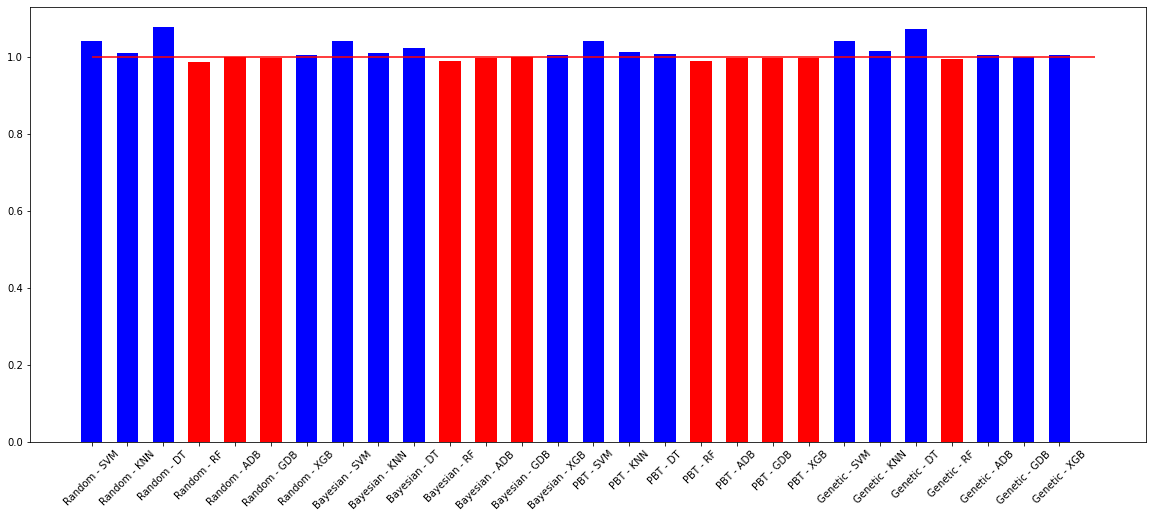

In [19]:
c = []
for s in sc:
  if s<1.0:
    c.append('red')
  else:
    c.append('blue')

plt.figure(figsize=(20,8))
plt.bar(np.arange(len(sc)),sc, width=0.6, color = c)
plt.hlines(1.0, 0, len(sc), colors='red')
plt.xticks(np.arange(len(names)), names, rotation=45)
plt.show()

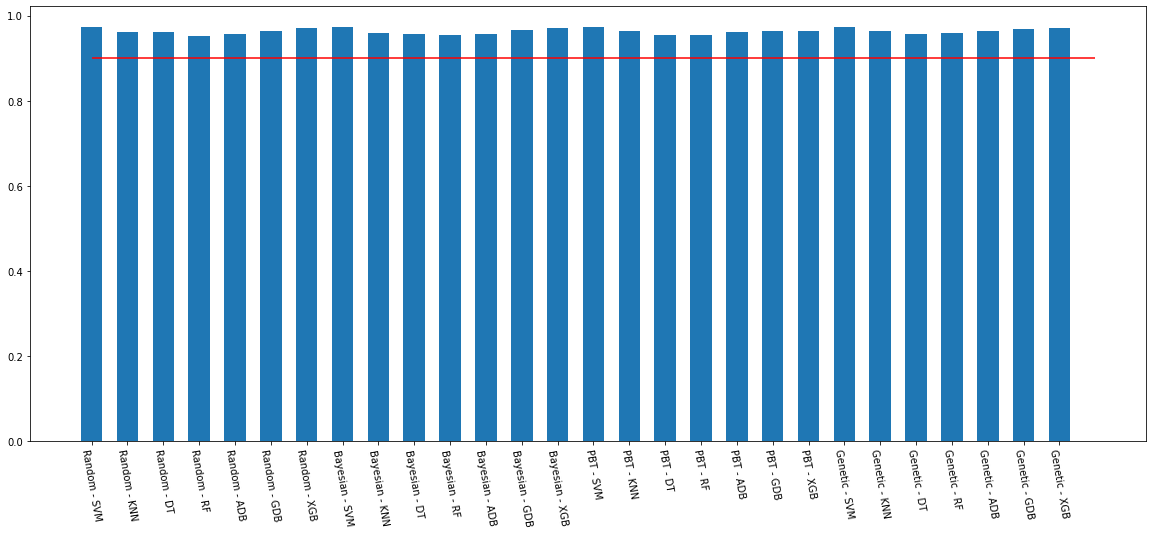

In [20]:
plt.figure(figsize=(20,8))
plt.bar(np.arange(len(sc)),sct, width=0.6)
plt.hlines(0.9, 0, len(sc), colors='red')
plt.xticks(np.arange(len(names)), names, rotation=280)
plt.show()

### Resultados NN

In [32]:
randomNN = RandomSearchNN()
bayesNN = BayesianSearchNN()
geneticNN = GeneticSearchNN()
pbtNN = PBTSearchNN()

In [34]:
models = [randomNN, bayesNN]

opt = ['Random', 'Bayesian']
names = []
sc =[]
scd=[]
sct=[]
tm = []
tmt=[]

for i,m in enumerate(models):
    nome = str(opt[i])
    names.append(nome)
    m.search(X_train, X_test, y_train, y_test)
    sc.append(m.score)
    scd.append(m.score_default)
    sct.append(m.score_tuned)
    tm.append(m.time)
    tmt.append(m.time_tuned)

Epoch 1/20
6/6 [==============================] - 0s 3ms/step - loss: 32463.3887
Epoch 2/20
6/6 [==============================] - 0s 2ms/step - loss: 32262.2812
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 32151.9746
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 32108.9355
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 32035.7441
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 32025.1816
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 31964.9844
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 31941.6699
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 31911.9688
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 31893.5391
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 31830.0410
Epoch 12/20
6/6 [==============================] - 0s 2ms/step - loss: 31827.6270
Epoch 13/20
6/6 [========

3/3 [==============================] - 0s 2ms/step - loss: 33266.4297
Epoch 1/5
6/6 [==============================] - 0s 2ms/step - loss: 33015.6406
Epoch 2/5
6/6 [==============================] - 0s 2ms/step - loss: 33010.5977
Epoch 3/5
6/6 [==============================] - 0s 2ms/step - loss: 33004.4766
Epoch 4/5
6/6 [==============================] - 0s 2ms/step - loss: 33000.6523
Epoch 5/5
6/6 [==============================] - 0s 2ms/step - loss: 32999.3555


3/3 [==============================] - 0s 3ms/step - loss: 32732.1445
Epoch 1/20
6/6 [==============================] - 0s 2ms/step - loss: 32840.0078
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 32721.0117
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 32646.3242
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 32604.6445
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 32574.6855
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 32548.1953
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 32523.3184
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 32499.0195
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 32474.1094
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 32446.5957
Epoch 11/20
6/6 [==============================] - 0s 1ms/step - loss: 32417.0645
Epoch 12/20
6/6 [====================

3/3 [==============================] - 0s 3ms/step - loss: 32267.1270
Epoch 1/20
6/6 [==============================] - 0s 3ms/step - loss: 33025.6328
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 32746.3887
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 32617.0410
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 32545.4707
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 32493.1406
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 32448.0957
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 32412.5039
Epoch 8/20
6/6 [==============================] - 0s 1ms/step - loss: 32384.3613
Epoch 9/20
6/6 [==============================] - 0s 1ms/step - loss: 32357.7598
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 32332.0469
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 32308.2148
Epoch 12/20
6/6 [====================

3/3 [==============================] - 0s 3ms/step - loss: 32316.1172
Epoch 1/20
6/6 [==============================] - 0s 2ms/step - loss: 32664.6270
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 32544.9160
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 32465.3535
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 32405.8535
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 32358.3223
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 32318.3418
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 32282.0195
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 32247.9219
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 32217.5996
Epoch 10/20
6/6 [==============================] - 0s 1ms/step - loss: 32190.9258
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 32166.4805
Epoch 12/20
6/6 [====================

3/3 [==============================] - 0s 2ms/step - loss: 31711.7383
Epoch 1/20
11/11 [==============================] - 0s 5ms/step - loss: 17123.2930
Epoch 2/20
11/11 [==============================] - 0s 3ms/step - loss: 10245.1152
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 7274.7812
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 5578.2988
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 3986.9705
Epoch 6/20
11/11 [==============================] - 0s 3ms/step - loss: 2925.5466
Epoch 7/20
11/11 [==============================] - 0s 3ms/step - loss: 2765.0273
Epoch 8/20
11/11 [==============================] - 0s 2ms/step - loss: 2403.6672
Epoch 9/20
11/11 [==============================] - 0s 2ms/step - loss: 2310.4465
Epoch 10/20
11/11 [==============================] - 0s 2ms/step - loss: 2399.1094
Epoch 11/20
11/11 [==============================] - 0s 2ms/step - loss: 2569.0496
Epoch 12/20
11/11 [=====

6/6 [==============================] - 0s 3ms/step - loss: 242.6380
Epoch 1/20
11/11 [==============================] - 0s 2ms/step - loss: 29013.9199
Epoch 2/20
11/11 [==============================] - 0s 2ms/step - loss: 20809.1055
Epoch 3/20
11/11 [==============================] - 0s 2ms/step - loss: 15855.1416
Epoch 4/20
11/11 [==============================] - 0s 2ms/step - loss: 11110.8311
Epoch 5/20
11/11 [==============================] - 0s 2ms/step - loss: 6919.9258
Epoch 6/20
11/11 [==============================] - 0s 2ms/step - loss: 4361.6182
Epoch 7/20
11/11 [==============================] - 0s 1ms/step - loss: 2889.5496
Epoch 8/20
11/11 [==============================] - 0s 2ms/step - loss: 2644.2810
Epoch 9/20
11/11 [==============================] - 0s 2ms/step - loss: 2526.4734
Epoch 10/20
11/11 [==============================] - 0s 2ms/step - loss: 2389.2114
Epoch 11/20
11/11 [==============================] - 0s 2ms/step - loss: 2182.0271
Epoch 12/20
11/11 [=====

2/2 [==============================] - 0s 3ms/step - loss: 32857.2500
Epoch 1/10
3/3 [==============================] - 0s 2ms/step - loss: 33313.9023
Epoch 2/10
3/3 [==============================] - 0s 2ms/step - loss: 33305.1055
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 33332.7188
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 33325.6523
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 33329.9492
Epoch 6/10
3/3 [==============================] - 0s 4ms/step - loss: 33307.4453
Epoch 7/10
3/3 [==============================] - 0s 997us/step - loss: 33302.5898
Epoch 8/10
3/3 [==============================] - 0s 3ms/step - loss: 33297.5938
Epoch 9/10
3/3 [==============================] - 0s 1ms/step - loss: 33309.8984
Epoch 10/10
3/3 [==============================] - 0s 1ms/step - loss: 33306.3867


2/2 [==============================] - 0s 2ms/step - loss: 33507.3359
Epoch 1/10
3/3 [==============================] - 0s 2ms/step - loss: 33119.6250
Epoch 2/10
3/3 [==============================] - 0s 4ms/step - loss: 33113.7344
Epoch 3/10
3/3 [==============================] - 0s 5ms/step - loss: 33121.1875
Epoch 4/10
3/3 [==============================] - 0s 4ms/step - loss: 33110.0664
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 33105.4570
Epoch 6/10
3/3 [==============================] - 0s 3ms/step - loss: 33104.5625
Epoch 7/10
3/3 [==============================] - 0s 4ms/step - loss: 33118.9805
Epoch 8/10
3/3 [==============================] - 0s 3ms/step - loss: 33106.7070
Epoch 9/10
3/3 [==============================] - 0s 4ms/step - loss: 33102.2188
Epoch 10/10
3/3 [==============================] - 0s 3ms/step - loss: 33102.8906


2/2 [==============================] - 0s 2ms/step - loss: 32840.8125
Epoch 1/15
3/3 [==============================] - 0s 15ms/step - loss: 28761.2715
Epoch 2/15
3/3 [==============================] - 0s 11ms/step - loss: 8939.5674
Epoch 3/15
3/3 [==============================] - 0s 3ms/step - loss: 2374.2581
Epoch 4/15
3/3 [==============================] - 0s 3ms/step - loss: 855.8380
Epoch 5/15
3/3 [==============================] - 0s 4ms/step - loss: 530.2497
Epoch 6/15
3/3 [==============================] - 0s 3ms/step - loss: 458.7123
Epoch 7/15
3/3 [==============================] - 0s 3ms/step - loss: 446.2542
Epoch 8/15
3/3 [==============================] - 0s 5ms/step - loss: 441.2148
Epoch 9/15
3/3 [==============================] - 0s 3ms/step - loss: 439.9209
Epoch 10/15
3/3 [==============================] - 0s 3ms/step - loss: 439.7224
Epoch 11/15
3/3 [==============================] - 0s 3ms/step - loss: 440.3594
Epoch 12/15
3/3 [==============================] - 0s

2/2 [==============================] - 0s 1ms/step - loss: 491.4814
Epoch 1/15
3/3 [==============================] - 0s 3ms/step - loss: 27455.4180
Epoch 2/15
3/3 [==============================] - 0s 3ms/step - loss: 9797.8428
Epoch 3/15
3/3 [==============================] - 0s 3ms/step - loss: 3284.0098
Epoch 4/15
3/3 [==============================] - 0s 3ms/step - loss: 1332.9003
Epoch 5/15
3/3 [==============================] - 0s 3ms/step - loss: 730.5225
Epoch 6/15
3/3 [==============================] - 0s 4ms/step - loss: 552.1594
Epoch 7/15
3/3 [==============================] - 0s 3ms/step - loss: 498.1995
Epoch 8/15
3/3 [==============================] - 0s 3ms/step - loss: 482.3916
Epoch 9/15
3/3 [==============================] - 0s 3ms/step - loss: 476.9313
Epoch 10/15
3/3 [==============================] - 0s 3ms/step - loss: 474.8226
Epoch 11/15
3/3 [==============================] - 0s 3ms/step - loss: 475.1827
Epoch 12/15
3/3 [==============================] - 0s 4m

2/2 [==============================] - 0s 2ms/step - loss: 421.2881
Epoch 1/15
3/3 [==============================] - 0s 2ms/step - loss: 29064.9883
Epoch 2/15
3/3 [==============================] - 0s 3ms/step - loss: 10200.7949
Epoch 3/15
3/3 [==============================] - 0s 3ms/step - loss: 2663.6653
Epoch 4/15
3/3 [==============================] - 0s 2ms/step - loss: 956.2637
Epoch 5/15
3/3 [==============================] - 0s 3ms/step - loss: 572.8765
Epoch 6/15
3/3 [==============================] - 0s 2ms/step - loss: 482.6631
Epoch 7/15
3/3 [==============================] - 0s 2ms/step - loss: 462.6727
Epoch 8/15
3/3 [==============================] - 0s 3ms/step - loss: 456.5299
Epoch 9/15
3/3 [==============================] - 0s 2ms/step - loss: 456.6284
Epoch 10/15
3/3 [==============================] - 0s 3ms/step - loss: 456.3909
Epoch 11/15
3/3 [==============================] - 0s 2ms/step - loss: 457.4659
Epoch 12/15
3/3 [==============================] - 0s 3m

2/2 [==============================] - 0s 4ms/step - loss: 458.3717
Epoch 1/20
21/21 [==============================] - 0s 1ms/step - loss: 32449.1250
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 32241.5391
Epoch 3/20
21/21 [==============================] - 0s 1ms/step - loss: 32083.8730
Epoch 4/20
21/21 [==============================] - 0s 1ms/step - loss: 32014.9941
Epoch 5/20
21/21 [==============================] - 0s 1ms/step - loss: 31939.7910
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 31836.8730
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 31795.1094
Epoch 8/20
21/21 [==============================] - 0s 1ms/step - loss: 31779.3262
Epoch 9/20
21/21 [==============================] - 0s 1ms/step - loss: 31688.0566
Epoch 10/20
21/21 [==============================] - 0s 2ms/step - loss: 31589.3730
Epoch 11/20
21/21 [==============================] - 0s 1ms/step - loss: 31556.2246
Epoch 12/20
21/21

11/11 [==============================] - 0s 2ms/step - loss: 31178.2695
Epoch 1/20
21/21 [==============================] - 0s 2ms/step - loss: 32672.1953
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 32529.6289
Epoch 3/20
21/21 [==============================] - 0s 3ms/step - loss: 32426.7734
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 32369.5020
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 32311.5352
Epoch 6/20
21/21 [==============================] - 0s 1ms/step - loss: 32255.6504
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 32211.0059
Epoch 8/20
21/21 [==============================] - 0s 2ms/step - loss: 32117.5703
Epoch 9/20
21/21 [==============================] - 0s 2ms/step - loss: 32093.8887
Epoch 10/20
21/21 [==============================] - 0s 2ms/step - loss: 32050.2559
Epoch 11/20
21/21 [==============================] - 0s 1ms/step - loss: 32008.4082
Epoch 12/20
2

KeyboardInterrupt: 

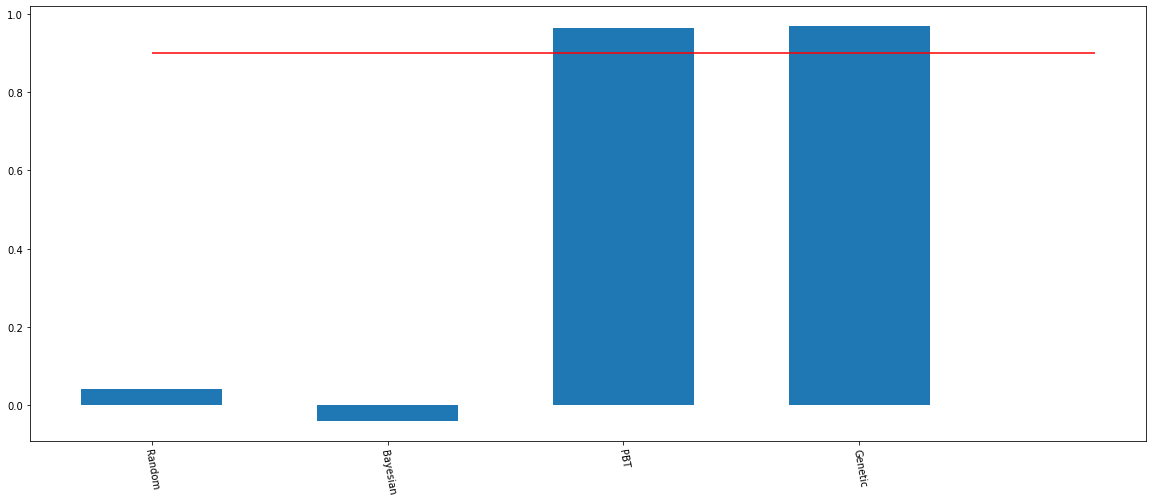

In [31]:
plt.figure(figsize=(20,8))
plt.bar(np.arange(len(sc)),sct, width=0.6)
plt.hlines(0.9, 0, len(sc), colors='red')
plt.xticks(np.arange(len(names)), names, rotation=280)
plt.show()